**Timeseries Forecasting:**
- TSFresh for time series forecasting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.linear_model import LinearRegression

**Reading the Data:**
- download the data from stooq - and only store the high value. 

In [3]:
df = web.DataReader("AAPL","stooq")["High"]
df.head()

Date
2025-07-11    212.13
2025-07-10    213.48
2025-07-09    211.33
2025-07-08    211.43
2025-07-07    216.23
Name: High, dtype: float64

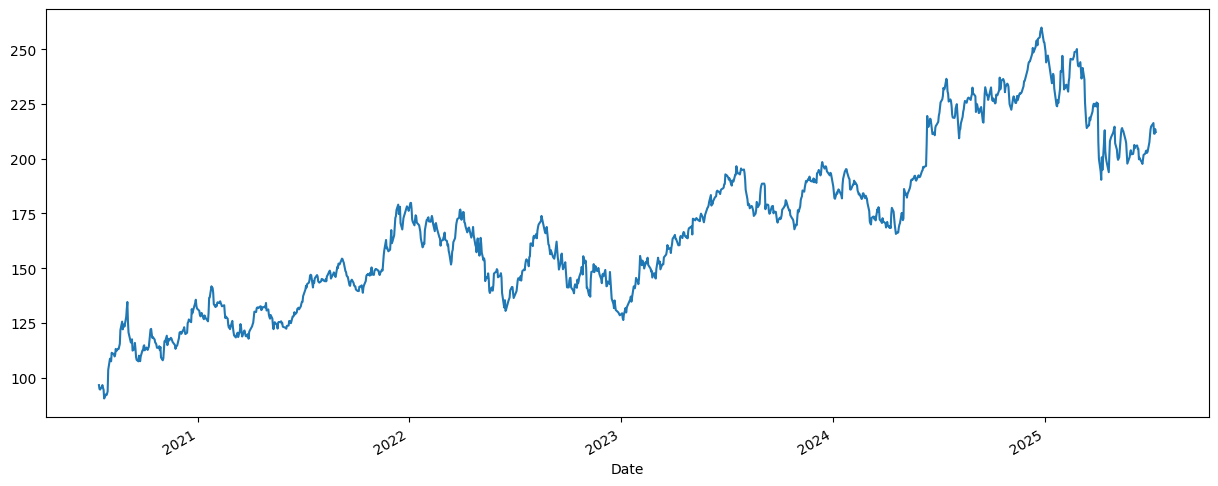

In [4]:
plt.figure(figsize = (15,6))
df.plot(ax = plt.gca())
plt.show()

We want to make the time dependency a bit clearer and add an identifier to each of the stock values

In [5]:
df.head()

Date
2025-07-11    212.13
2025-07-10    213.48
2025-07-09    211.33
2025-07-08    211.43
2025-07-07    216.23
Name: High, dtype: float64

In [6]:
df_melted = pd.DataFrame({"high": df.copy()})

In [7]:
df_melted.head()

,high
Date,
2025-07-11,212.13
2025-07-10,213.48
2025-07-09,211.33
2025-07-08,211.43
2025-07-07,216.23


In [9]:
df_melted['date'] = df_melted.index
df_melted['Symbols'] = 'AAPL'

In [10]:
df_melted.head()

,high,date,Symbols
Date,,,
2025-07-11,212.13,2025-07-11,AAPL
2025-07-10,213.48,2025-07-10,AAPL
2025-07-09,211.33,2025-07-09,AAPL
2025-07-08,211.43,2025-07-08,AAPL
2025-07-07,216.23,2025-07-07,AAPL


**Creating a training data sample:**
- Forecasting typically involves the following steps
  - Take up all data up to today
  - do feature extraction (e.g. by running extract_features)
  - run a prediction model (e.g. a regressor - see below)
  - use the result as the forecast for tomorrow.

In training however, we need multiple examples to train. If we would only use the time series until today (and wait for the value to have a target), we would only have a single training example. Therefore we use a trick: we replay the history.

Imagine - you have a cut-out window sliding over your data. At each time step t, you treat the data as it would be today. You extract the features with everything you know until today - which is all the data until and including t. the target for the features until time t is the time vcalue of time t+1. 

The process of window sliding is implemented in the function roll_time_series. Our window size will be 20 (we look at max 20 days in the past). and we disregard all windows shorter than 5 days

In [11]:
df_melted

,high,date,Symbols
Date,,,
2025-07-11,212.1300,2025-07-11,AAPL
2025-07-10,213.4800,2025-07-10,AAPL
2025-07-09,211.3300,2025-07-09,AAPL
2025-07-08,211.4300,2025-07-08,AAPL
2025-07-07,216.2300,2025-07-07,AAPL
...,...,...,...
2020-07-21,96.6056,2020-07-21,AAPL
2020-07-20,95.8754,2020-07-20,AAPL
2020-07-17,94.5589,2020-07-17,AAPL


In [15]:
df_melted['date'].dtype

dtype('<M8[ns]')

In [12]:
df_rolled = roll_time_series(df_melted, column_id = "Symbols", column_sort = "date", max_timeshift = 20, min_timeshift = 5)

c:\Users\blais\Documents\ML\venv2\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 40/40 [00:02<00:00, 14.60it/s]


In [14]:
df_rolled.head()

,high,date,Symbols,id
1344,96.6036,2020-07-15,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1345,94.8091,2020-07-16,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1346,94.5589,2020-07-17,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1347,95.8754,2020-07-20,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1348,96.6056,2020-07-21,AAPL,"(AAPL, 2020-07-22 00:00:00)"


Resulting dataframe consosts of these windows - stamped out of the original dataframe. For example all the data with id = (AAPL, 2020-07-22 00:00:00) comes from the original data of stock of AAPL including the last 20 days until 2020-07-22.

In [17]:
df_rolled[df_rolled["id"] == ("AAPL", pd.to_datetime("2020-07-22"))]

,high,date,Symbols,id
1344,96.6036,2020-07-15,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1345,94.8091,2020-07-16,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1346,94.5589,2020-07-17,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1347,95.8754,2020-07-20,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1348,96.6056,2020-07-21,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1349,95.3630,2020-07-22,AAPL,"(AAPL, 2020-07-22 00:00:00)"


In [18]:
df_melted[(df_melted["date"] <= pd.to_datetime("2020-07-22")) &
          (df_melted["date"] >= pd.to_datetime("2020-06-23")) &
          (df_melted["Symbols"] == "AAPL")
]

,high,date,Symbols
Date,,,
2020-07-22,95.3630,2020-07-22,AAPL
2020-07-21,96.6056,2020-07-21,AAPL
2020-07-20,95.8754,2020-07-20,AAPL
2020-07-17,94.5589,2020-07-17,AAPL
2020-07-16,94.8091,2020-07-16,AAPL
2020-07-15,96.6036,2020-07-15,AAPL


If we now group by the new id column, each of the groups will be a certain stock symbol until and including the daya intil a certain day ( and including the last 20 days in the past.)

In [19]:
len(df_melted)

1254

In [20]:
df_rolled["id"].nunique()

1249

In [21]:
df_rolled.groupby("id").size().agg([np.min, np.max])

C:\Users\blais\AppData\Local\Temp\ipykernel_25232\3711842531.py:1: FutureWarning: The provided callable <function min at 0x000001A6727AF2E0> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_rolled.groupby("id").size().agg([np.min, np.max])
C:\Users\blais\AppData\Local\Temp\ipykernel_25232\3711842531.py:1: FutureWarning: The provided callable <function max at 0x000001A6727AF1C0> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_rolled.groupby("id").size().agg([np.min, np.max])


min     6
max    21
dtype: int64

In [22]:
df_rolled

,high,date,Symbols,id
1344,96.6036,2020-07-15,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1345,94.8091,2020-07-16,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1346,94.5589,2020-07-17,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1347,95.8754,2020-07-20,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1348,96.6056,2020-07-21,AAPL,"(AAPL, 2020-07-22 00:00:00)"
...,...,...,...,...
24088,216.2300,2025-07-07,AAPL,"(AAPL, 2025-07-11 00:00:00)"
24089,211.4300,2025-07-08,AAPL,"(AAPL, 2025-07-11 00:00:00)"
24090,211.3300,2025-07-09,AAPL,"(AAPL, 2025-07-11 00:00:00)"
24091,213.4800,2025-07-10,AAPL,"(AAPL, 2025-07-11 00:00:00)"


In [23]:
df_melted

,high,date,Symbols
Date,,,
2025-07-11,212.1300,2025-07-11,AAPL
2025-07-10,213.4800,2025-07-10,AAPL
2025-07-09,211.3300,2025-07-09,AAPL
2025-07-08,211.4300,2025-07-08,AAPL
2025-07-07,216.2300,2025-07-07,AAPL
...,...,...,...
2020-07-21,96.6056,2020-07-21,AAPL
2020-07-20,95.8754,2020-07-20,AAPL
2020-07-17,94.5589,2020-07-17,AAPL


In [24]:
df_rolled

,high,date,Symbols,id
1344,96.6036,2020-07-15,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1345,94.8091,2020-07-16,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1346,94.5589,2020-07-17,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1347,95.8754,2020-07-20,AAPL,"(AAPL, 2020-07-22 00:00:00)"
1348,96.6056,2020-07-21,AAPL,"(AAPL, 2020-07-22 00:00:00)"
...,...,...,...,...
24088,216.2300,2025-07-07,AAPL,"(AAPL, 2025-07-11 00:00:00)"
24089,211.4300,2025-07-08,AAPL,"(AAPL, 2025-07-11 00:00:00)"
24090,211.3300,2025-07-09,AAPL,"(AAPL, 2025-07-11 00:00:00)"
24091,213.4800,2025-07-10,AAPL,"(AAPL, 2025-07-11 00:00:00)"


**Extract Features:**
- The rolled (windowed) data sample is now in the correct format to use if for tsfresh's feature extraction. As normal features will b extracted using all the data for a given id, which is in our case all data of a given window and a given id. If the featire extraction returns a row with the index (AAPL, 2020-07-14 00:00:00) - you know it has been calculated using the AAPL data up and including 2020-07-14 (and 20 days of history).

In [25]:
X = extract_features(df_rolled.drop("Symbols", axis=1),
                    column_id = "id", column_sort="date", column_value="high", impute_function = impute,
                    show_warnings=False)

Feature Extraction: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


In [26]:
X.head()

high__variance_larger_than_standard_deviation  ...  high__mean_n_absolute_max__number_of_maxima_7
AAPL 2020-07-22                                            0.0  ...                                     171.618714
     2020-07-23                                            0.0  ...                                     171.618714
     2020-07-24                                            1.0  ...                                      95.472214
     2020-07-27                                            1.0  ...                                      95.472214
     2020-07-28                                            1.0  ...                                      95.472214

[5 rows x 783 columns]

We now make the data a bit easier to work with by removing the tuple index

In [28]:
X.index.map(lambda x: x[1])

DatetimeIndex(['2020-07-22', '2020-07-23', '2020-07-24', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-03', '2020-08-04',
               ...
               '2025-06-27', '2025-06-30', '2025-07-01', '2025-07-02',
               '2025-07-03', '2025-07-07', '2025-07-08', '2025-07-09',
               '2025-07-10', '2025-07-11'],
              dtype='datetime64[ns]', length=1249, freq=None)

In [29]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,high__mean,high__length,high__standard_deviation,high__variation_coefficient,high__variance,high__skewness,high__kurtosis,high__root_mean_square,high__absolute_sum_of_changes,high__longest_strike_below_mean,high__longest_strike_above_mean,high__count_above_mean,high__count_below_mean,high__last_location_of_maximum,high__first_location_of_maximum,high__last_location_of_minimum,high__first_location_of_minimum,high__percentage_of_reoccurring_values_to_all_values,high__percentage_of_reoccurring_datapoints_to_all_datapoints,high__sum_of_reoccurring_values,high__sum_of_reoccurring_data_points,high__ratio_value_number_to_time_series_length,high__sample_entropy,high__maximum,high__absolute_maximum,high__minimum,high__benford_correlation,high__time_reversal_asymmetry_statistic__lag_1,high__time_reversal_asymmetry_statistic__lag_2,high__time_reversal_asymmetry_statistic__lag_3,...,high__number_crossing_m__m_1,high__energy_ratio_by_chunks__num_segments_10__segment_focus_0,high__energy_ratio_by_chunks__num_segments_10__segment_focus_1,high__energy_ratio_by_chunks__num_segments_10__segment_focus_2,high__energy_ratio_by_chunks__num_segments_10__segment_focus_3,high__energy_ratio_by_chunks__num_segments_10__segment_focus_4,high__energy_ratio_by_chunks__num_segments_10__segment_focus_5,high__energy_ratio_by_chunks__num_segments_10__segment_focus_6,high__energy_ratio_by_chunks__num_segments_10__segment_focus_7,high__energy_ratio_by_chunks__num_segments_10__segment_focus_8,high__energy_ratio_by_chunks__num_segments_10__segment_focus_9,high__ratio_beyond_r_sigma__r_0.5,high__ratio_beyond_r_sigma__r_1,high__ratio_beyond_r_sigma__r_1.5,high__ratio_beyond_r_sigma__r_2,high__ratio_beyond_r_sigma__r_2.5,high__ratio_beyond_r_sigma__r_3,high__ratio_beyond_r_sigma__r_5,high__ratio_beyond_r_sigma__r_6,high__ratio_beyond_r_sigma__r_7,high__ratio_beyond_r_sigma__r_10,high__count_above__t_0,high__count_below__t_0,high__lempel_ziv_complexity__bins_2,high__lempel_ziv_complexity__bins_3,high__lempel_ziv_complexity__bins_5,high__lempel_ziv_complexity__bins_10,high__lempel_ziv_complexity__bins_100,high__fourier_entropy__bins_2,high__fourier_entropy__bins_3,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-22,0.0,0.0,0.0,0.0,573.8156,54881.242590,1.066800,-0.248120,0.068988,95.61920,95.635933,6.0,0.801262,0.008378,0.642021,-0.001505,-2.024788,95.639290,5.3340,2.0,2.0,3.0,3.0,0.833333,0.666667,0.500000,0.333333,0.0,0.0,0.0,0.0,1.0,1.098612,96.6056,96.6056,94.5589,-0.297356,2553.440631,5067.850853,0.000000,...,0.0,0.170045,0.163786,0.162922,0.167491,0.170052,0.165705,0.000000,0.000000,0.000000,0.00000,0.666667,0.666667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.666667,0.666667,0.833333,0.833333,0.693147,0.693147,1.039721,1.039721,1.039721,1.386294,1.098612,0.693147,-0.000000,2.708050,0.0,171.618714
2020-07-23,0.0,0.0,0.0,0.0,668.3055,63809.583793,1.034517,-0.352283,0.092140,95.36300,95.472214,7.0,0.843283,0.008833,0.711127,0.298600,-1.918273,95.475938,6.2071,2.0,2.0,3.0,4.0,0.714286,0.571429,1.000000,0.857143,0.0,0.0,0.0,0.0,1.0,1.098612,96.6056,96.6056,94.4899,-0.297356,-5668.313967,2958.514262,-38725.448046,...,0.0,0.146252,0.140869,0.140126,0.144055,0.146258,0.142519,0.139922,0.000000,0.000000,0.00000,0.714286,0.571429,0.000000,0.000000,0.0,0.0,

In [30]:
X.loc['2020-07-22']

high__variance_larger_than_standard_deviation                0.000000
high__has_duplicate_max                                      0.000000
high__has_duplicate_min                                      0.000000
high__has_duplicate                                          0.000000
high__sum_values                                           573.815600
                                                              ...    
high__permutation_entropy__dimension_5__tau_1                0.693147
high__permutation_entropy__dimension_6__tau_1               -0.000000
high__permutation_entropy__dimension_7__tau_1                2.708050
high__query_similarity_count__query_None__threshold_0.0      0.000000
high__mean_n_absolute_max__number_of_maxima_7              171.618714
Name: 2020-07-22 00:00:00, Length: 783, dtype: float64

Just to reiterate - the features in this row were only calculated using the time series values of AAPL upto and including 2020-07-22 and the last 20 days.

**Prediction:**
- We can now use the extracted features to train a regressor. What will the targets be - the target for the row 2020-07-13 is the value on the next time step (which would be 2020-07-23 in this case)
- So, all we need to do is go back to the original dataframe and taje the stock value of the next day (tomorrow). This is done with shift

In [ ]:
df_melted.set_index("date").sort_index().high

date
2020-07-15     96.6036
2020-07-16     94.8091
2020-07-17     94.5589
2020-07-20     95.8754
2020-07-21     96.6056
                ...   
2025-07-07    216.2300
2025-07-08    211.4300
2025-07-09    211.3300
2025-07-10    213.4800
2025-07-11    212.1300
Name: high, Length: 1254, dtype: float64

In [34]:
df_melted.set_index("date").sort_index().high.shift(-1)

date
2020-07-15     94.8091
2020-07-16     94.5589
2020-07-17     95.8754
2020-07-20     96.6056
2020-07-21     95.3630
                ...   
2025-07-07    211.4300
2025-07-08    211.3300
2025-07-09    213.4800
2025-07-10    212.1300
2025-07-11         NaN
Name: high, Length: 1254, dtype: float64

In [35]:
y = df_melted.set_index("date").sort_index().high.shift(-1)

In [40]:
df_melted.shape, df_rolled.shape

((1254, 3), (26109, 4))

In [41]:
X.shape

(1249, 783)

Quick consistency test:

In [37]:
y["2020-07-21"],df["2020-07-22"]

(95.363, 95.363)

However - we need to careful, as  - X is missing the first 5 dates (as our minimum window size was 5), and y is missing the last date. 

In [38]:
y.shape

(1254,)

In [39]:
X.shape

(1249, 783)

In [42]:
# making sure to have a consistent view on the data
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

We can now train normal AdaBoost Regressors to predict the next time step. Lets split the data into a training and testing sample (but make sure to keep temporal consistency). We take everything till 2020 as train data and the rest as test:

In [43]:
X[:"2020"]

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,high__mean,high__length,high__standard_deviation,high__variation_coefficient,high__variance,high__skewness,high__kurtosis,high__root_mean_square,high__absolute_sum_of_changes,high__longest_strike_below_mean,high__longest_strike_above_mean,high__count_above_mean,high__count_below_mean,high__last_location_of_maximum,high__first_location_of_maximum,high__last_location_of_minimum,high__first_location_of_minimum,high__percentage_of_reoccurring_values_to_all_values,high__percentage_of_reoccurring_datapoints_to_all_datapoints,high__sum_of_reoccurring_values,high__sum_of_reoccurring_data_points,high__ratio_value_number_to_time_series_length,high__sample_entropy,high__maximum,high__absolute_maximum,high__minimum,high__benford_correlation,high__time_reversal_asymmetry_statistic__lag_1,high__time_reversal_asymmetry_statistic__lag_2,high__time_reversal_asymmetry_statistic__lag_3,...,high__number_crossing_m__m_1,high__energy_ratio_by_chunks__num_segments_10__segment_focus_0,high__energy_ratio_by_chunks__num_segments_10__segment_focus_1,high__energy_ratio_by_chunks__num_segments_10__segment_focus_2,high__energy_ratio_by_chunks__num_segments_10__segment_focus_3,high__energy_ratio_by_chunks__num_segments_10__segment_focus_4,high__energy_ratio_by_chunks__num_segments_10__segment_focus_5,high__energy_ratio_by_chunks__num_segments_10__segment_focus_6,high__energy_ratio_by_chunks__num_segments_10__segment_focus_7,high__energy_ratio_by_chunks__num_segments_10__segment_focus_8,high__energy_ratio_by_chunks__num_segments_10__segment_focus_9,high__ratio_beyond_r_sigma__r_0.5,high__ratio_beyond_r_sigma__r_1,high__ratio_beyond_r_sigma__r_1.5,high__ratio_beyond_r_sigma__r_2,high__ratio_beyond_r_sigma__r_2.5,high__ratio_beyond_r_sigma__r_3,high__ratio_beyond_r_sigma__r_5,high__ratio_beyond_r_sigma__r_6,high__ratio_beyond_r_sigma__r_7,high__ratio_beyond_r_sigma__r_10,high__count_above__t_0,high__count_below__t_0,high__lempel_ziv_complexity__bins_2,high__lempel_ziv_complexity__bins_3,high__lempel_ziv_complexity__bins_5,high__lempel_ziv_complexity__bins_10,high__lempel_ziv_complexity__bins_100,high__fourier_entropy__bins_2,high__fourier_entropy__bins_3,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-22,0.0,0.0,0.0,0.0,573.8156,54881.242590,1.066800,-0.248120,0.068988,95.61920,95.635933,6.0,0.801262,0.008378,0.642021,-0.001505,-2.024788,95.639290,5.3340,2.0,2.0,3.0,3.0,0.833333,0.666667,0.500000,0.333333,0.0,0.0,0.0,0.0,1.0,1.098612,96.6056,96.6056,94.5589,-0.297356,2553.440631,5067.850853,0.000000,...,0.0,0.170045,0.163786,0.162922,0.167491,0.170052,0.165705,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.666667,0.666667,0.833333,0.833333,0.693147,0.693147,1.039721,1.039721,1.039721,1.386294,1.098612,0.693147,-0.000000,2.708050,0.0,171.618714
2020-07-23,0.0,0.0,0.0,0.0,668.3055,63809.583793,1.034517,-0.352283,0.092140,95.36300,95.472214,7.0,0.843283,0.008833,0.711127,0.298600,-1.918273,95.475938,6.2071,2.0,2.0,3.0,4.0,0.714286,0.571429,1.000000,0.857143,0.0,0.0,0.0,0.0,1.0,1.098612,96.6056,96.6056,94.4899,-0.297356,-5668.313967,2958.514262,-38725.448046,...,0.0,0.146252,0.140869,0.140126,0.144055,0.146258,0.142519,0.139922,0.000000,0.000000,0.000000,0.714286,0.571429,0.000000,0.000000,0.0,0.

In [44]:
X_train = X[:"2020"]
X_test = X["2021":]

y_train = y[:"2020"]
y_test = y["2021":]

In [46]:
X_train.head()

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,high__mean,high__length,high__standard_deviation,high__variation_coefficient,high__variance,high__skewness,high__kurtosis,high__root_mean_square,high__absolute_sum_of_changes,high__longest_strike_below_mean,high__longest_strike_above_mean,high__count_above_mean,high__count_below_mean,high__last_location_of_maximum,high__first_location_of_maximum,high__last_location_of_minimum,high__first_location_of_minimum,high__percentage_of_reoccurring_values_to_all_values,high__percentage_of_reoccurring_datapoints_to_all_datapoints,high__sum_of_reoccurring_values,high__sum_of_reoccurring_data_points,high__ratio_value_number_to_time_series_length,high__sample_entropy,high__maximum,high__absolute_maximum,high__minimum,high__benford_correlation,high__time_reversal_asymmetry_statistic__lag_1,high__time_reversal_asymmetry_statistic__lag_2,high__time_reversal_asymmetry_statistic__lag_3,...,high__number_crossing_m__m_1,high__energy_ratio_by_chunks__num_segments_10__segment_focus_0,high__energy_ratio_by_chunks__num_segments_10__segment_focus_1,high__energy_ratio_by_chunks__num_segments_10__segment_focus_2,high__energy_ratio_by_chunks__num_segments_10__segment_focus_3,high__energy_ratio_by_chunks__num_segments_10__segment_focus_4,high__energy_ratio_by_chunks__num_segments_10__segment_focus_5,high__energy_ratio_by_chunks__num_segments_10__segment_focus_6,high__energy_ratio_by_chunks__num_segments_10__segment_focus_7,high__energy_ratio_by_chunks__num_segments_10__segment_focus_8,high__energy_ratio_by_chunks__num_segments_10__segment_focus_9,high__ratio_beyond_r_sigma__r_0.5,high__ratio_beyond_r_sigma__r_1,high__ratio_beyond_r_sigma__r_1.5,high__ratio_beyond_r_sigma__r_2,high__ratio_beyond_r_sigma__r_2.5,high__ratio_beyond_r_sigma__r_3,high__ratio_beyond_r_sigma__r_5,high__ratio_beyond_r_sigma__r_6,high__ratio_beyond_r_sigma__r_7,high__ratio_beyond_r_sigma__r_10,high__count_above__t_0,high__count_below__t_0,high__lempel_ziv_complexity__bins_2,high__lempel_ziv_complexity__bins_3,high__lempel_ziv_complexity__bins_5,high__lempel_ziv_complexity__bins_10,high__lempel_ziv_complexity__bins_100,high__fourier_entropy__bins_2,high__fourier_entropy__bins_3,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-22,0.0,0.0,0.0,0.0,573.8156,54881.242590,1.066800,-0.248120,0.068988,95.61920,95.635933,6.0,0.801262,0.008378,0.642021,-0.001505,-2.024788,95.639290,5.3340,2.0,2.0,3.0,3.0,0.833333,0.666667,0.500000,0.333333,0.0,0.0,0.0,0.0,1.0,1.098612,96.6056,96.6056,94.5589,-0.297356,2553.440631,5067.850853,0.000000,...,0.0,0.170045,0.163786,0.162922,0.167491,0.170052,0.165705,0.000000,0.000000,0.000000,0.00000,0.666667,0.666667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.666667,0.666667,0.833333,0.833333,0.693147,0.693147,1.039721,1.039721,1.039721,1.386294,1.098612,0.693147,-0.000000,2.708050,0.0,171.618714
2020-07-23,0.0,0.0,0.0,0.0,668.3055,63809.583793,1.034517,-0.352283,0.092140,95.36300,95.472214,7.0,0.843283,0.008833,0.711127,0.298600,-1.918273,95.475938,6.2071,2.0,2.0,3.0,4.0,0.714286,0.571429,1.000000,0.857143,0.0,0.0,0.0,0.0,1.0,1.098612,96.6056,96.6056,94.4899,-0.297356,-5668.313967,2958.514262,-38725.448046,...,0.0,0.146252,0.140869,0.140126,0.144055,0.146258,0.142519,0.139922,0.000000,0.000000,0.00000,0.714286,0.571429,0.000000,0.000000,0.0,0.0,

In [47]:
y_train.head()

date
2020-07-22    94.4899
2020-07-23    90.4915
2020-07-24    92.3759
2020-07-27    92.0290
2020-07-28    92.6895
Name: high, dtype: float64

Do feature selection before training:

In [48]:
X_train_selected = select_features(X_train, y_train)

In [49]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_selected, y_train)

LinearRegression()

Now, lets check how good our prediction is:

In [50]:
X_test_selected = X_test[X_train_selected.columns]
y_pred = pd.Series(lin_reg.predict(X_test_selected), index = X_test_selected.index)

<AxesSubplot:xlabel='last_date'>

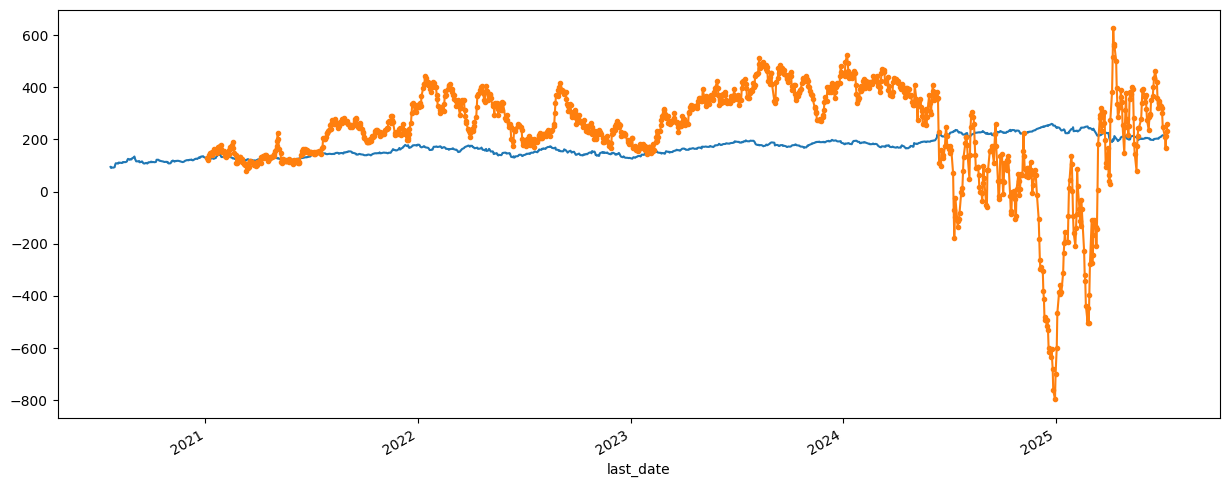

In [51]:
plt.figure(figsize=(15, 6))

y.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")